In [2]:
import numpy as np
import xarray as xr

from eval_utilities import spatial_temporal_metrics as stm
from eval_utilities import visualization as vis
import matplotlib.pyplot as plt

import pandas as pd

import os
import glob

/data/conda/envs/ailand/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [3]:
import yaml
with open(f"config.yaml") as stream:
    try:
        CONFIG = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
# load the predicted variables
variables = CONFIG["targets_prog"] + CONFIG["targets_diag"]


In [4]:
# load all the ensemble members and collect into 
# load ensembles name in a list
# prepare the numpy ensemble array

def find_files_with_name(directory, filename):
    # Create a pattern for glob
    pattern = os.path.join(directory, f'*{filename}*')
    
    # Use glob to find all files matching the pattern
    matching_files = glob.glob(pattern)
    
    return matching_files

# Example usage
directory_path = '/data/ch23/data_ch23'  # Replace with your folder path
file_name = 'mlp'  # File name to search for
files_list = find_files_with_name(directory_path, file_name)

# preprocess .zarr to np.array
ens_file_list=[]
for i,ens_file in enumerate(files_list):

    ens1=xr.open_zarr(ens_file)
    desired_chunks = (4, 10051, 17)  # Adjust based on your desired chunk sizes
    ens1 = ens1.chunk({'time': 4, 'x': 10051, 'variable': 17})
    ens1_array=ens1.data.values
    ens_file_list.append(ens1_array)

stacked_ens = np.stack(ens_file_list)
y_pred=stacked_ens

/data/conda/envs/ailand/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [5]:
# load groundtruth
v1=xr.open_zarr("/data/ch23/data_ch23/euro_mlp_v1_train_2010_2019_val_2020_2020.zarr")

train_ds = xr.open_zarr("/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr").sel(time=slice("2020", "2022"),variable=variables)  
# select the same variable list as prediction
y_true=train_ds.data.values

In [8]:
variables

['swvl1',
 'swvl2',
 'swvl3',
 'stl1',
 'stl2',
 'stl3',
 'snowc',
 'd2m',
 't2m',
 'skt',
 'sshf',
 'slhf',
 'aco2gpp',
 'dis',
 'e',
 'sro',
 'ssro']

### visualize the ensemble at one grid point for one variable

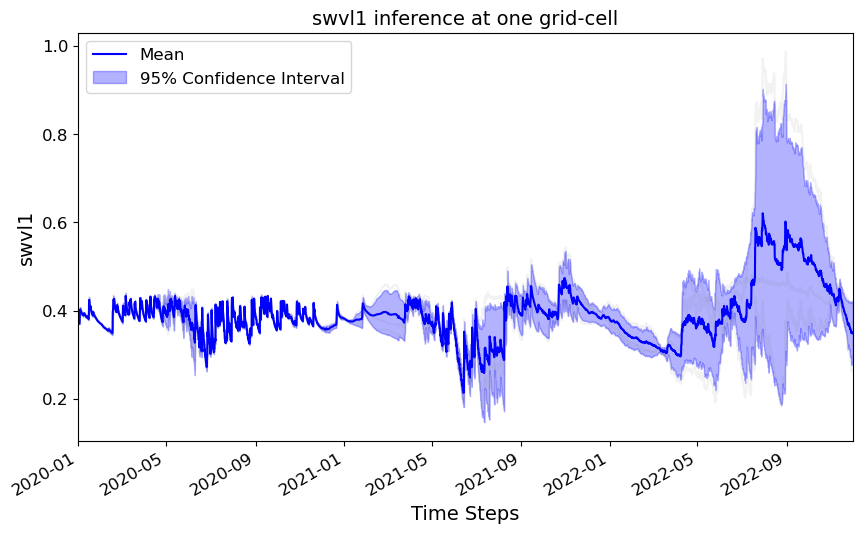

In [6]:
# choose one grid point and one variable, showing the time series -- probably one part of the time series
# only for one grid point

data=y_pred[:,:,1000,0] # customize the grid points and the variables
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
confidence_interval = 1.96 * std / np.sqrt(data.shape[0])
# Generate datetime index
date_range = pd.date_range(start='2020-01-01 00:00:00', end='2022-11-30 18:00:00', periods=4260)
# Plotting
plt.figure(figsize=(10, 6))

# Plot each realization
for i in range(data.shape[0]):
    plt.plot(date_range,data[i], color='gray', alpha=0.1)

# Plot the mean time series
plt.plot(date_range,mean, color='blue', label='Mean')

# Shade the confidence interval
plt.fill_between(date_range, mean - confidence_interval, mean + confidence_interval, color='blue', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('swvl1', fontsize=14)
plt.title('swvl1 inference at one grid-cell', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(pd.Timestamp('2020-01-01 00:00:00'), pd.Timestamp('2022-11-30 18:00:00'))
plt.gcf().autofmt_xdate()
plt.show()

In [36]:
def crps(y_true, y_pred, time=True, sample_weight=None, norm=False):
    """
    Calculate Continuous Ranked Probability Score
    Data based on size (time, lat*lon, vars) where N=number of samples (in time) and each grid point will have one value
    Args:
        y_true (np.array): Ground truth with shape (time, lat*lon, vars).
        y_pred (np.array): Predicted values from n_seeds ensembles with shape (n_seeds, time, lat*lon, vars).
        sample_weight (np.array, optional): Sample weights.
        norm (bool, optional): Flag to normalize the CRPS scores.
    
    Returns:
        np.array: CRPS score for each height profile (lat*lon, vars).Returns:
        
    modified based on@https://github.com/lm2612/WaveNet_UQ/
    """
    # Number of ensemble predictions
    num_samples = y_pred.shape[0]
    
    # Sort predictions along the ensemble axis
    y_pred = np.sort(y_pred, axis=0)
    
    # Calculate differences between consecutive sorted predictions
    diff = y_pred[1:] - y_pred[:-1]
    
    # Calculate weights for CRPS calculation
    weight = np.arange(1, num_samples) * np.arange(num_samples - 1, 0, -1)
    weight = weight[:, np.newaxis, np.newaxis, np.newaxis]
    
    # Calculate the absolute error
    absolute_error = np.mean(np.abs(y_pred - np.expand_dims(y_true, 0)), axis=0)
    
    # Calculate per observation CRPS
    per_obs_crps = absolute_error - np.sum(diff * weight, axis=0) / num_samples**2

    if time==False:
        return per_obs_crps

    # Normalization if required
    if norm:
        crps_normalized = np.where(np.abs(y_true) > 1E-14, per_obs_crps / np.abs(y_true), np.nan)
        return np.nanmean(crps_normalized, axis=0)
    
    # Return the weighted average CRPS
    if time:
        return np.average(per_obs_crps, axis=0, weights=sample_weight)

In [20]:
# sometime could have the RAM problem, we cannot calculate 17 variables at the same time...
# problem of numpy, but not figure out the way to calculate in .zarr
# in that case, split the calculation

crps_score = crps(y_true[:,:,:17], y_pred[:,:,:,:17], sample_weight=None, norm=False)

# Calculate CRPS
#crps_scores = crps(y_true, y_pred)

# Create a new xarray Dataset with CRPS scores
crps_ds = xr.Dataset(
    {
        "crps": (("x", "variable"), crps_score)
    },
    coords={
        "lat": ("x", v1.lat.values),
        "lon": ("x", v1.lon.values),
        "variable": v1.variable.values,
    }
)
# Save the new dataset as a .zarr file
crps_ds.to_zarr("/data/ch23/evalution_results/uncertainty/crps_mlp_test.zarr")

In [ ]:
def crpss(y_true, y_pred, y_ref):
    """Calculate Continuous Ranked Probability Skill Score
    Args:
     * y_true : np.array (time, lat*lon) ground truth
     * y_pred : np.array (n_seeds, time, lat*lon) predicted from model
     * y_ref : np.array (n_seeds, time, lat*lon) reference prediction -- what is this?
    """
    crps_model = crps(y_true, y_pred)
    crps_ref = crps(y_true, y_ref)
    return 1 - (crps_model / crps_ref)

In [ ]:
# calculate the crpss:
# what is the ref?

### Plot CRPS and CRPSS for different variables but for the entire inference time period

In [20]:
# visualize the crpss and crps in boxplot for all the variables -- the boxplot is representing the stack of the grid points
# The necessity to have the normalized crps or crpss -- since crps is related to the original magnitude of the variable itself

crps=xr.open_zarr("/data/ch23/evalution_results/uncertainty/crps_mlp_test.zarr")
data = crps.crps.data  # This will be a numpy array of shape (10051, 17)
variables = crps.crps.coords['variable'].values  # Variable names

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
data_transposed = data.T
# Create a boxplot for each variable
ax.boxplot(data_transposed, labels=variables)

# Customize the plot
ax.set_title('Boxplot for each variable', fontsize=16)
ax.set_xlabel('Variables', fontsize=16)
ax.set_ylabel('CRPS', fontsize=16)
ax.set_ylim([-1, 1000000])
plt.xticks(rotation=45, fontsize=12)  # Rotate variable names for better readability
plt.yticks(fontsize=12) 
plt.tight_layout()

# Show the plot
plt.show()


### plot CRPS and CRPSS for one variable but for different period of inference time, as well as the confidence interval of the score

In [37]:
# the confidence interval comes from 10051 grid points

# choose one variable, showing the time series -- probably one part of the time series
# this can be plotted for all grid points, showing the confidence interval, but only one variable each time

crps_score_time_series = crps(y_true[:,:,:17], y_pred[:,:,:,:17], time=False, sample_weight=None, norm=False)



/data/conda/envs/ailand/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


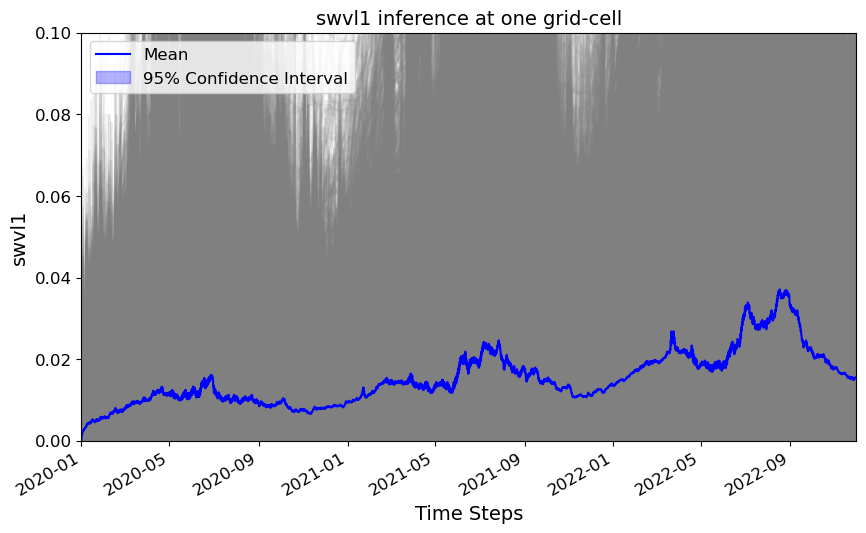

In [43]:
data=crps_score_time_series[:,:,0] # customize the grid points and the variables
data=data.T
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)
confidence_interval = 1.96 * std / np.sqrt(data.shape[0])
# Generate datetime index
date_range = pd.date_range(start='2020-01-01 00:00:00', end='2022-11-30 18:00:00', periods=4260)


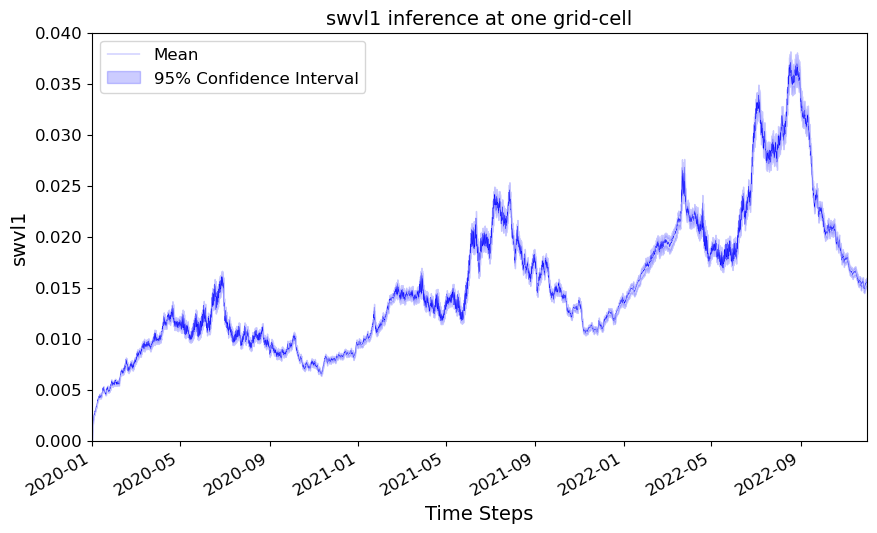

In [53]:
# visualization

plt.figure(figsize=(10, 6))

# Plot each realization
#for i in range(data.shape[0]):
#    plt.plot(date_range,data[i], color='gray', alpha=0.1)

# Plot the mean time series
plt.plot(date_range,mean, color='blue', label='Mean', linewidth=0.2)

# Shade the confidence interval
plt.fill_between(date_range, mean - confidence_interval, mean + confidence_interval, color='blue', alpha=0.2, label='95% Confidence Interval')

plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('swvl1', fontsize=14)
plt.title('swvl1 inference at one grid-cell', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(pd.Timestamp('2020-01-01 00:00:00'), pd.Timestamp('2022-11-30 18:00:00'))
plt.ylim(0,0.04)
plt.gcf().autofmt_xdate()
plt.show()

### Uncertainty against Error

In [55]:
# only can be done for individual variable -- can only be calculated for one variable
# Each individual point represents a single prediction at one timestep and grid-cell
# Using MAE and Confidence interval

(4260, 10051, 17)

In [10]:
# Define the vectors
y_true_var = y_true[:,:,0]
y_pred_var =y_pred[:,:,:,0]
# Step 1: Expand y_true to match the shape of array for broadcasting
y_true_expanded = np.expand_dims(y_true_var, axis=0)  # Shape becomes (1, 4260, 10051)

# Step 2: Calculate the absolute errors
absolute_errors = np.abs(y_pred_var - y_true_expanded)

# Step 3: Compute the mean absolute error across ensembles
ensemble_error = np.mean(absolute_errors, axis=0)

# Step 4: calculating the std
std = np.std(y_pred_var, axis=0)

ValueError: Contour levels must be increasing

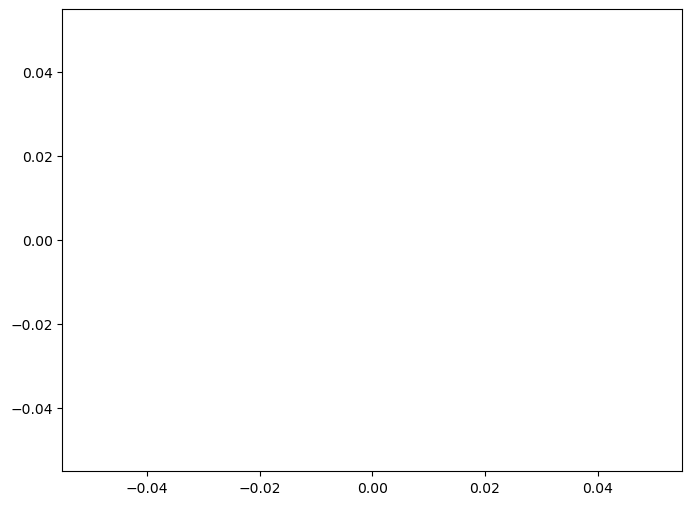

In [15]:
# Flatten the arrays to plot each point
import seaborn as sns

ensemble_error_flat = ensemble_error.flatten()
std_flat = std.flatten()

# Plotting the scatter plot with density shading
# Plotting the scatter plot with density shading
plt.figure(figsize=(8, 6))

sns.kdeplot(x=ensemble_error_flat, y=std_flat, cmap="Reds", fill=True, thresh=False, levels=100)
#plt.scatter(ensemble_error_flat, y_true_flat, c='orange', alpha=0.5, s=1)
plt.plot([0, max(ensemble_error_flat)], [0, max(std_flat)], 'k--', linewidth=1)
plt.xlabel('Ensemble Mean Absolute Error (ms^-2)')
plt.ylabel('standard deviation')
plt.title('Ensemble uncertainty against ensemble error')

plt.show()

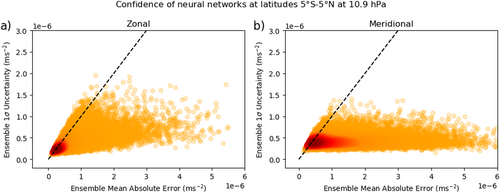

#### Characteristics of a good ensemble
Forecasts from a good ensemble should: 

display no mean errors (bias); otherwise the probabilities will be biased as well.
exhibit sharpness (i.e. have relatively small spread where the uncertainty is small).
have the ability to span the full climatological range; otherwise the probabilities will either over- or under-forecast the risks of anomalous or extreme weather events.

https://confluence.ecmwf.int/display/FUG/Section+5+Forecast+Ensemble+%28ENS%29+-+Rationale+and+Construction

#### Reasoning of not estimate aleatoric uncertainty in the training data, and we also do not consider structural uncertainty -- only parametric uncertainty, a type of epistemic uncertainty